In [46]:
import pandas as pd
import numpy as np
from collections import Counter

In [2]:
df = pd.read_csv("mabel.txt",header=None,on_bad_lines='skip',encoding='utf8')

In [3]:
df=df.drop(0)
df.columns=['Date','Chat']
Message=df["Chat"].str.split("-",n=1,expand=True)
df["Time"]=Message[0]
Message1=Message[1].str.split(":",n=1,expand=True)
df["Name"]=Message1[0]
df["Chat"]=Message1[1]
df=df[["Date","Time","Name","Chat"]]
df.head()

,Date,Time,Name,Chat
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K
4,05/12/19,1:42 pm,Mabel Infoziant,Ok
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 1 to 50
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    50 non-null     object
 1   Time    50 non-null     object
 2   Name    50 non-null     object
 3   Chat    50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [13]:
# !pip install vaderSentiment

In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def is_flirt(text):
    vs = analyzer.polarity_scores(text)
    # Flirtation tends to have high positive sentiment and low negativity
    if vs['compound'] > 0.5 and vs['neg'] < 0.1:
        return "yes"
    return "no"

df['Flirt'] = df['Chat'].apply(is_flirt)

In [22]:
df.head(5)

,Date,Time,Name,Chat,Flirt
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke,no
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name,no
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K,no
4,05/12/19,1:42 pm,Mabel Infoziant,Ok,no
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com,no


In [40]:
message_counts = df['Name'].value_counts().reset_index()
message_counts

,Name,count
0,AR❤,27
1,Mabel Infoziant,23


In [32]:
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# 1. Talkative/Less Talkative (by message count)
message_counts = df['Name'].value_counts().reset_index()
message_counts.columns = ['Name', 'Message_count']
talkative_threshold = message_counts['Message_count'].quantile(0.75)
less_talkative_threshold = message_counts['Message_count'].quantile(0.25)

message_counts['Talkativeness'] = np.where(
    message_counts['Message_count'] >= talkative_threshold, 
    'Talkative',
    np.where(
        message_counts['Message_count'] <= less_talkative_threshold,
        'Less Talkative',
        'Average'
    )
)

C:\Users\Pavithira\AppData\Local\Temp\ipykernel_10296\3169780344.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])


In [34]:
message_counts

,Name,Message_count,Talkativeness
0,AR❤,27,Talkative
1,Mabel Infoziant,23,Less Talkative


In [42]:
df['day_of_week'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

df.head()

,Date,Time,Name,Chat,Flirt,datetime,day_of_week,hour
1,05/12/19,1:42 pm,Mabel Infoziant,Hi this is Mabel we just spoke,no,2019-05-12 13:42:00,Sunday,13
2,05/12/19,1:42 pm,Mabel Infoziant,What’s your full name,no,2019-05-12 13:42:00,Sunday,13
3,05/12/19,1:42 pm,AR❤,Ramisha Rani K,no,2019-05-12 13:42:00,Sunday,13
4,05/12/19,1:42 pm,Mabel Infoziant,Ok,no,2019-05-12 13:42:00,Sunday,13
5,05/12/19,1:42 pm,Mabel Infoziant,ramisharanik@gmail.com,no,2019-05-12 13:42:00,Sunday,13


In [90]:
def get_most_common(series):
    counts = Counter(series)
    print(counts)
    most_common = counts.most_common(1)
    print(most_common)
    return most_common[0][0] if most_common else None

most_active = df.groupby('Name').agg({
    'day_of_week': get_most_common,
    'hour': get_most_common
}).reset_index()

most_active.columns = ['Name', 'Most_active_day', 'Most_active_hour']

Counter({'Sunday': 13, 'Thursday': 8, 'Wednesday': 3, 'Monday': 2, 'Saturday': 1})
[('Sunday', 13)]
Counter({'Sunday': 14, 'Thursday': 4, 'Saturday': 2, 'Wednesday': 2, 'Monday': 1})
[('Sunday', 14)]
Counter({12: 8, 13: 6, 14: 3, 20: 3, 15: 3, 23: 2, 16: 1, 8: 1})
[(12, 8)]
Counter({13: 10, 14: 3, 12: 3, 15: 2, 16: 1, 22: 1, 7: 1, 8: 1, 20: 1})
[(13, 10)]


In [92]:
most_active

,Name,Most_active_day,Most_active_hour
0,AR❤,Sunday,12
1,Mabel Infoziant,Sunday,13


In [52]:
missed_call_pattern = r'missed call|call missed'
df['is_missed_call'] = df['Chat'].str.contains(missed_call_pattern, case=False, na=False, regex=True)
missed_calls = df[df['is_missed_call']].groupby('Name').size().reset_index(name='missed_call_count')

In [54]:
missed_calls

,Name,missed_call_count


## Topic Modelling

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')
dtm=tfidf.fit_transform(df["Chat"])

In [60]:
from sklearn.decomposition import NMF
nmf_model=NMF(n_components=5,random_state=42)
nmf_model.fit(dtm)


NMF(n_components=5, random_state=42)

In [62]:
for index,topic in enumerate(nmf_model.components_):
    # print(tfidf.get_feature_names_out())
    # print(topic)
    results=([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]])
    print(results)

['share', 'soon', 'ask', 'yes', 'sure', 'read', 'abstract', 'kk', 'yeah', 'mam']
['hi', 'kk', 'know', 'meeting', 'yes', 'just', 'send', 'tomorrow', 'mam', 'ok']
['details', 'abstracts', 'start', 'students', 'phone', 'ask', 'office', 'number', 'vignesh', 'send']
['ask', 'abstracts', 'number', 'mam', 'office', 'know', 'just', 'tomorrow', 'church', 'hi']
['students', 'know', 'sure', 'share', 'soon', 'meeting', 'details', 'yes', 'need', 'ramisha']


In [64]:
topic_results=nmf_model.transform(dtm)
df["Topic"]=topic_results.argmax(axis=1)


In [72]:
df.sample(5)

,Date,Time,Name,Chat,Flirt,datetime,day_of_week,hour,is_missed_call,Topic
13,05/12/19,1:45 pm,AR❤,Tomorrow I have to visit the office.yet not I...,no,2019-05-12 13:45:00,Sunday,13,False,2
11,05/12/19,1:43 pm,Mabel Infoziant,Send me cbe office address and phone number I...,no,2019-05-12 13:43:00,Sunday,13,False,2
9,05/12/19,1:43 pm,AR❤,Yeah mam,no,2019-05-12 13:43:00,Sunday,13,False,0
33,09/12/19,12:26 pm,AR❤,If we finiliaze I can work with full involvem...,no,2019-09-12 12:26:00,Thursday,12,False,2
35,09/12/19,12:28 pm,AR❤,You deleted this message,no,2019-09-12 12:28:00,Thursday,12,False,0


In [74]:
df["Topic"].value_counts()

Topic
0    22
2    12
4     6
3     5
1     5
Name: count, dtype: int64

## Wordcloud

In [62]:
# !pip install wordCloud

In [77]:
dataset=df
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavithira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

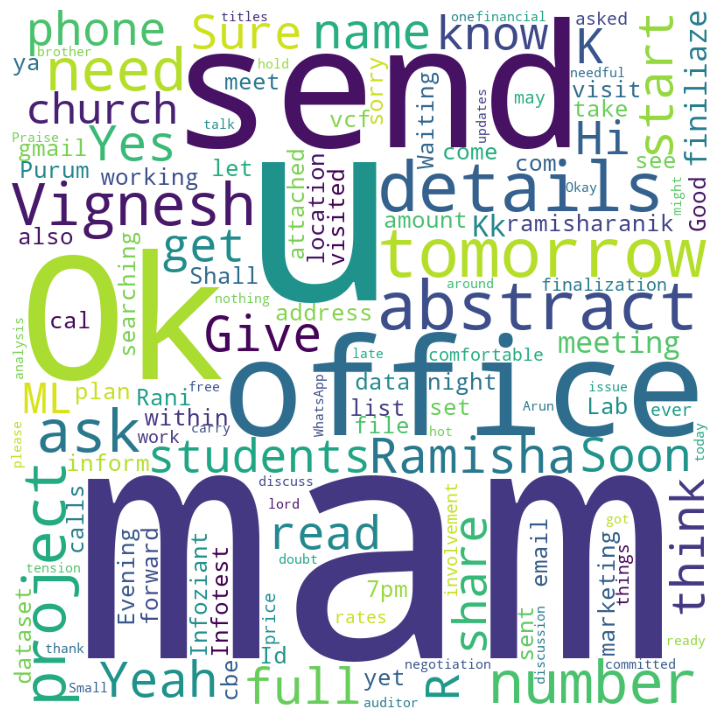

Successfully created


In [80]:

comment_words = []
stoplist = stopwords.words('english')
stoplist.extend(['omitted', 'voice','missed','call','video','deleted','media','message'])
wordcloudss="This function saves image"
dataset.index=range(dataset.shape[0])
for i in range(1,len(dataset)): 
    comment_words.append(dataset['Chat'][i])
    vv=" ".join(comment_words)          
    wordcloud = WordCloud(width = 800, height = 800, 
                                background_color ='white', 
                                      stopwords = stoplist, 
                                      min_font_size = 10).generate(vv)         
plt.figure(figsize = (9, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud.PNG')
plt.show() 
print("Successfully created")
wordcloudss="This function saves image"
